<a href="https://colab.research.google.com/github/ivan-meer/cookbook/blob/main/mistral/ocr/structured_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OCR Cookbook

---

## OCR Exploration and Structured Outputs
In this cookbook, we will explore the basics of OCR and leverage it together with existing models to achieve structured outputs fueled by our OCR model.

You may want to do this in case current vision models are not powerful enough, hence enhancing their vision OCR capabilities with the OCR model to achieve better structured data extraction.

---

### Used
- Mistral OCR
- Pixtral 12B & Ministral 8B


### Setup
First, let's install `mistralai` and download the required files.

In [3]:
!pip install mistralai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.3/278.3 kB 7.5 MB/s eta 0:00:00


In [4]:
!wget https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/ocr/mistral7b.pdf
!wget https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/ocr/receipt.png

--2025-03-10 02:22:55--  https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/ocr/mistral7b.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3749788 (3.6M) [application/octet-stream]
Saving to: ‘mistral7b.pdf’

mistral7b.pdf       100%[===================>]   3.58M  --.-KB/s    in 0.08s   

2025-03-10 02:22:56 (45.5 MB/s) - ‘mistral7b.pdf’ saved [3749788/3749788]

--2025-03-10 02:22:56--  https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/ocr/receipt.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting res

We can now set up our client. You can create an API key on our [Plateforme](https://console.mistral.ai/api-keys/).

In [5]:
from mistralai import Mistral

api_key = "ZqLKeD6hqm9pD4yR14u8VM6GuUGCghri"
client = Mistral(api_key=api_key)

There are two types of files you can apply OCR to:
- PDF files, either uploaded or from URLs...

In [6]:
from pathlib import Path

pdf_file = Path("/content/AgentQ.pdf")
assert pdf_file.is_file()

In [8]:
from mistralai import DocumentURLChunk, ImageURLChunk, TextChunk
import json

uploaded_file = client.files.upload(
    file={
        "file_name": pdf_file.stem,
        "content": pdf_file.read_bytes(),
    },
    purpose="ocr",
)

signed_url = client.files.get_signed_url(file_id=uploaded_file.id, expiry=1)

pdf_response = client.ocr.process(document=DocumentURLChunk(document_url=signed_url.url), model="mistral-ocr-latest", include_image_base64=True)

response_dict = json.loads(pdf_response.model_dump_json())
json_string = json.dumps(response_dict, indent=4)
print(json_string)

{
    "pages": [
        {
            "index": 0,
            "markdown": "# Agent Q: Advanced Reasoning and Learning for Autonomous AI Agents \n\nPranav Putta ${ }^{1}$, Edmund Mills ${ }^{1}$, Naman Garg ${ }^{1}$, Sumeet Motwani ${ }^{1}$, Elan Markowitz ${ }^{1}$, Chelsea Finn ${ }^{2}$, Divyansh Garg ${ }^{1}$ and Rafael Rafailov ${ }^{1,2}$<br>${ }^{1}$ The AGI Company (MultiOn), ${ }^{2}$ Stanford University\n\nLarge Language Models (LLMs) have shown remarkable capabilities in natural language tasks requiring complex reasoning, yet their application in agentic, multi-step reasoning within interactive environments remains a difficult challenge. Traditional supervised pre-training on static datasets falls short in enabling autonomous agent capabilities needed to perform complex decision-making in dynamic settings like web navigation. Previous attempts to bridge this gap-through supervised fine-tuning on curated expert demonstrations- often suffer from compounding errors and limit

*The OCR model can output interleaved text and images (set `include_image_base64=True` to return the base64 image ), we can view the result with the following:*

In [10]:
from mistralai.models import OCRResponse
from IPython.display import Markdown, display

def replace_images_in_markdown(markdown_str: str, images_dict: dict) -> str:
    for img_name, base64_str in images_dict.items():
        markdown_str = markdown_str.replace(f"![{img_name}]({img_name})", f"![{img_name}]({base64_str})")
    return markdown_str

def get_combined_markdown(ocr_response: OCRResponse) -> str:
  markdowns: list[str] = []
  for page in pdf_response.pages:
    image_data = {}
    for img in page.images:
      image_data[img.id] = img.image_base64
    markdowns.append(replace_images_in_markdown(page.markdown, image_data))

  return "\n\n".join(markdowns)

display(Markdown(get_combined_markdown(pdf_response)))

# Agent Q: Advanced Reasoning and Learning for Autonomous AI Agents 

Pranav Putta ${ }^{1}$, Edmund Mills ${ }^{1}$, Naman Garg ${ }^{1}$, Sumeet Motwani ${ }^{1}$, Elan Markowitz ${ }^{1}$, Chelsea Finn ${ }^{2}$, Divyansh Garg ${ }^{1}$ and Rafael Rafailov ${ }^{1,2}$<br>${ }^{1}$ The AGI Company (MultiOn), ${ }^{2}$ Stanford University

Large Language Models (LLMs) have shown remarkable capabilities in natural language tasks requiring complex reasoning, yet their application in agentic, multi-step reasoning within interactive environments remains a difficult challenge. Traditional supervised pre-training on static datasets falls short in enabling autonomous agent capabilities needed to perform complex decision-making in dynamic settings like web navigation. Previous attempts to bridge this gap-through supervised fine-tuning on curated expert demonstrations- often suffer from compounding errors and limited exploration data, resulting in sub-optimal policy outcomes. To overcome these challenges, we propose a framework that combines guided Monte Carlo Tree Search (MCTS) search with a self-critique mechanism and iterative fine-tuning on agent interactions using an off-policy variant of the Direct Preference Optimization (DPO) algorithm. Our method allows LLM agents to learn effectively from both successful and unsuccessful trajectories, thereby improving their generalization in complex, multi-step reasoning tasks. We validate our approach in the WebShop environment-a simulated e-commerce platform-where it consistently outperforms behavior cloning and reinforced fine-tuning baseline, and beats average human performance when equipped with the capability to do online search. In real-world booking scenarios, our methodology boosts Llama-3 70B model's zero-shot performance from $\mathbf{1 8 . 6 \%}$ to $\mathbf{8 1 . 7 \%}$ success rate (a $\mathbf{3 4 0 \%}$ relative increase) after a single day of data collection and further to $\mathbf{9 5 . 4 \%}$ with online search. We believe this represents a substantial leap forward in the capabilities of autonomous agents, paving the way for more sophisticated and reliable decision-making in real-world settings.

## 1. Introduction

The recent advances in Large Language Models (LLMs) represent a significant leap in artificial intelligence. Frontier models like ChatGPT (John Schulman et al., 2022), Gemini (Anil et al., 2023), Opus (Anthropic, 2024), and LLaMA-3 (Touvron et al., 2023) demonstrate promising reasoning capabilities that approach average human performance in a number of domains. These breakthroughs have extended the utility of LLMs from traditional chat and text-based applications to more dynamic, agentic roles, in which they do not just generate text but can take actions autonomously in a number of environments including code and software engineering (Holt et al., 2024; Zhang et al., 2024d; Jimenez et al., 2024; Yang et al., 2024), device control (Wang et al., 2024a; Zhang et al., 2023; Chen and Li, 2024) and web applications (Hong et al., 2023; Deng et al., 2023; Zhou et al., 2024b; Lai et al., 2024a; Gur et al., 2024) among others. However, despite these advancements, significant challenges persist: LLMs still struggle to generalize effectively in interactive, multi-step environments, since they are not native trained for such applications. This is true, even for some of the strongest models of the current generation, such as GPT-4 (Achiam et al., 2023).

A growing literature on agentic formulation seeks to address these issues; however these works mostly focus on building frameworks around prompt-based learning on existing models or limited fine-tuning on static datasets, and are thus limited by the base models' reasoning and decision making capabilities. Reasoning and planning have indeed been highlighted as core challenges for current LLMs. Since the seminal work on chain-of-thought reasoning (Wei et al., 2022), significant efforts have been made to improve these capabilities via prompt-based strategies (Kojima et al., 2022; Wang et al.,
































































- And Image files...

In [ ]:
image_file = Path("receipt.png")
assert image_file.is_file()

In [ ]:
import base64

encoded = base64.b64encode(image_file.read_bytes()).decode()
base64_data_url = f"data:image/jpeg;base64,{encoded}"

image_response = client.ocr.process(document=ImageURLChunk(image_url=base64_data_url), model="mistral-ocr-latest")

response_dict = json.loads(image_response.json())
json_string = json.dumps(response_dict, indent=4)
print(json_string)

{
    "pages": [
        {
            "index": 1,
            "markdown": "# PLACE FACE UP ON DASH <br> CITY OF PALO ALTO <br> NOT VALID FOR ONSTREET PARKING \n\nExpiration Date/Time 11:59 PM\n\nAUG 19, 2024\n\nPurchase Date/Time: 01:34pm Aug 19, 2024\nTotal Due: $\\$ 15.00$\nRate: Daily Parking\nTotal Paid: $\\$ 15.00$\nPmt Type: CC (Swipe)\nTicket \\#: 00005883\nS/N \\#: 520117260957\nSetting: Permit Machines\nMach Name: Civic Center\n\\#^^^^-1224, Visa\nDISPLAY FACE UP ON DASH\n\nPERMIT EXPIRES\nAT MIDNIGHT",
            "images": [],
            "dimensions": {
                "dpi": 200,
                "height": 3210,
                "width": 1806
            }
        }
    ],
    "model": "mistral-ocr-2503-completion",
    "usage_info": {
        "pages_processed": 1,
        "doc_size_bytes": null
    }
}


We want to be able to extract structured data from these files. For this, we will make use of `pixtral-12b-latest` and support it with our OCR model for better, high-quality answers.

In [ ]:
image_ocr_markdown = image_response.pages[0].markdown

chat_response = client.chat.complete(
    model="pixtral-12b-latest",
    messages=[
        {
            "role": "user",
            "content": [
                ImageURLChunk(image_url=base64_data_url),
                TextChunk(text=f"This is image's OCR in markdown:\n<BEGIN_IMAGE_OCR>\n{image_ocr_markdown}\n<END_IMAGE_OCR>.\nConvert this into a sensible structured json response. The output should be strictly be json with no extra commentary")
            ],
        },
    ],
    response_format =  {"type": "json_object"},
    temperature=0
)

response_dict = json.loads(chat_response.choices[0].message.content)
json_string = json.dumps(response_dict, indent=4)
print(json_string)

{
    "parking_receipt": {
        "header": {
            "instructions": "PLACE FACE UP ON DASH",
            "city": "CITY OF PALO ALTO",
            "validity": "NOT VALID FOR ONSTREET PARKING"
        },
        "expiration": {
            "date_time": "11:59 PM",
            "date": "AUG 19, 2024"
        },
        "purchase": {
            "date_time": "01:34pm Aug 19, 2024"
        },
        "payment": {
            "total_due": "$15.00",
            "rate": "Daily Parking",
            "total_paid": "$15.00",
            "payment_type": "CC (Swipe)"
        },
        "details": {
            "ticket_number": "00005883",
            "serial_number": "520117260957",
            "setting": "Permit Machines",
            "machine_name": "Civic Center"
        },
        "footer": {
            "card_number": "#^^^^-1224",
            "card_type": "Visa",
            "instructions": "DISPLAY FACE UP ON DASH",
            "expiration_reminder": "PERMIT EXPIRES AT MIDNIGHT"
      

Note: We are leveraging a model already capable of vision tasks. However, we could also use text-only models for the structured output.

In [ ]:
image_ocr_markdown = image_response.pages[0].markdown

chat_response = client.chat.complete(
    model="ministral-8b-latest",
    messages=[
        {
            "role": "user",
            "content": f"This is image's OCR in markdown:\n<BEGIN_IMAGE_OCR>\n{image_ocr_markdown}\n<END_IMAGE_OCR>.\nConvert this into a sensible structured json response. The output should be strictly be json with no extra commentary"
        },
    ],
    response_format =  {"type": "json_object"},
    temperature=0
)

response_dict = json.loads(chat_response.choices[0].message.content)
json_string = json.dumps(response_dict, indent=4)
print(json_string)

{
    "expiration_date_time": "11:59 PM",
    "expiration_date": "AUG 19, 2024",
    "purchase_date_time": "01:34pm Aug 19, 2024",
    "total_due": 15.0,
    "rate": "Daily Parking",
    "total_paid": 15.0,
    "payment_type": "CC (Swipe)",
    "ticket_number": "00005883",
    "serial_number": "520117260957",
    "setting": "Permit Machines",
    "machine_name": "Civic Center",
    "card_number": "1224, Visa"
}


### All Together
Let's design a simple function that takes an `image_path` file and returns a JSON structured output in a specific format. In this case, we arbitrarily decided we wanted an output respecting the following:

```python
class StructuredOCR:
    file_name: str  # can be any string
    topics: list[str]  # must be a list of strings
    languages: list[Language]  # a list of languages
    ocr_contents: dict  # any dictionary, can be freely defined by the model
```

We will make use of [custom structured outputs](https://docs.mistral.ai/capabilities/structured-output/custom_structured_output/) as well as `pycountry` for the languages.

In [ ]:
!pip install pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 39.8 MB/s eta 0:00:00


In [ ]:
from enum import Enum
from pathlib import Path
from pydantic import BaseModel
import base64
import pycountry

languages = {lang.alpha_2: lang.name for lang in pycountry.languages if hasattr(lang, 'alpha_2')}

class LanguageMeta(Enum.__class__):
    def __new__(metacls, cls, bases, classdict):
        for code, name in languages.items():
            classdict[name.upper().replace(' ', '_')] = name
        return super().__new__(metacls, cls, bases, classdict)

class Language(Enum, metaclass=LanguageMeta):
    pass

class StructuredOCR(BaseModel):
    file_name: str
    topics: list[str]
    languages: list[Language]
    ocr_contents: dict

print(StructuredOCR.schema_json())

def structured_ocr(image_path: str) -> StructuredOCR:
    image_file = Path(image_path)
    assert image_file.is_file(), "The provided image path does not exist."

    # Read and encode the image file
    encoded_image = base64.b64encode(image_file.read_bytes()).decode()
    base64_data_url = f"data:image/jpeg;base64,{encoded_image}"

    # Process the image using OCR
    image_response = client.ocr.process(document=ImageURLChunk(image_url=base64_data_url), model="mistral-ocr-latest")
    image_ocr_markdown = image_response.pages[0].markdown

    # Parse the OCR result into a structured JSON response
    chat_response = client.chat.parse(
        model="pixtral-12b-latest",
        messages=[
            {
                "role": "user",
                "content": [
                    ImageURLChunk(image_url=base64_data_url),
                    TextChunk(text=(
                        "This is the image's OCR in markdown:\n"
                        f"<BEGIN_IMAGE_OCR>\n{image_ocr_markdown}\n<END_IMAGE_OCR>.\n"
                        "Convert this into a structured JSON response with the OCR contents in a sensible dictionnary."
                    ))
                ],
            },
        ],
        response_format=StructuredOCR,
        temperature=0
    )

    return chat_response.choices[0].message.parsed

{"$defs": {"Language": {"enum": ["Afar", "Abkhazian", "Afrikaans", "Akan", "Amharic", "Arabic", "Aragonese", "Assamese", "Avaric", "Avestan", "Aymara", "Azerbaijani", "Bashkir", "Bambara", "Belarusian", "Bengali", "Bislama", "Tibetan", "Bosnian", "Breton", "Bulgarian", "Catalan", "Czech", "Chamorro", "Chechen", "Church Slavic", "Chuvash", "Cornish", "Corsican", "Cree", "Welsh", "Danish", "German", "Dhivehi", "Dzongkha", "Modern Greek (1453-)", "English", "Esperanto", "Estonian", "Basque", "Ewe", "Faroese", "Persian", "Fijian", "Finnish", "French", "Western Frisian", "Fulah", "Scottish Gaelic", "Irish", "Galician", "Manx", "Guarani", "Gujarati", "Haitian", "Hausa", "Serbo-Croatian", "Hebrew", "Herero", "Hindi", "Hiri Motu", "Croatian", "Hungarian", "Armenian", "Igbo", "Ido", "Sichuan Yi", "Inuktitut", "Interlingue", "Interlingua (International Auxiliary Language Association)", "Indonesian", "Inupiaq", "Icelandic", "Italian", "Javanese", "Japanese", "Kalaallisut", "Kannada", "Kashmiri", 

We can now extract structured output from any image parsed with our OCR model.

In [ ]:
image_path = "receipt.png"
structured_response = structured_ocr(image_path)

response_dict = json.loads(structured_response.json())
json_string = json.dumps(response_dict, indent=4)
print(json_string)

{
    "file_name": "parking_receipt",
    "topics": [
        "Parking Receipt",
        "Expiration",
        "Payment"
    ],
    "languages": [
        "English"
    ],
    "ocr_contents": {
        "header": "PLACE FACE UP ON DASH",
        "city": "CITY OF PALO ALTO",
        "validity": "NOT VALID FOR ONSTREET PARKING",
        "expiration": {
            "date": "AUG 19, 2024",
            "time": "11:59 PM"
        },
        "purchase": {
            "date": "Aug 19, 2024",
            "time": "01:34pm"
        },
        "total_due": "$15.00",
        "rate": "Daily Parking",
        "total_paid": "$15.00",
        "payment_type": "CC (Swipe)",
        "ticket_number": "00005883",
        "serial_number": "520117260957",
        "setting": "Permit Machines",
        "machine_name": "Civic Center",
        "card_info": "#^^^^-1224, Visa",
        "instructions": "DISPLAY FACE UP ON DASH",
        "expiry_message": "PERMIT EXPIRES AT MIDNIGHT"
    }
}


The original image for comparison can be found below.

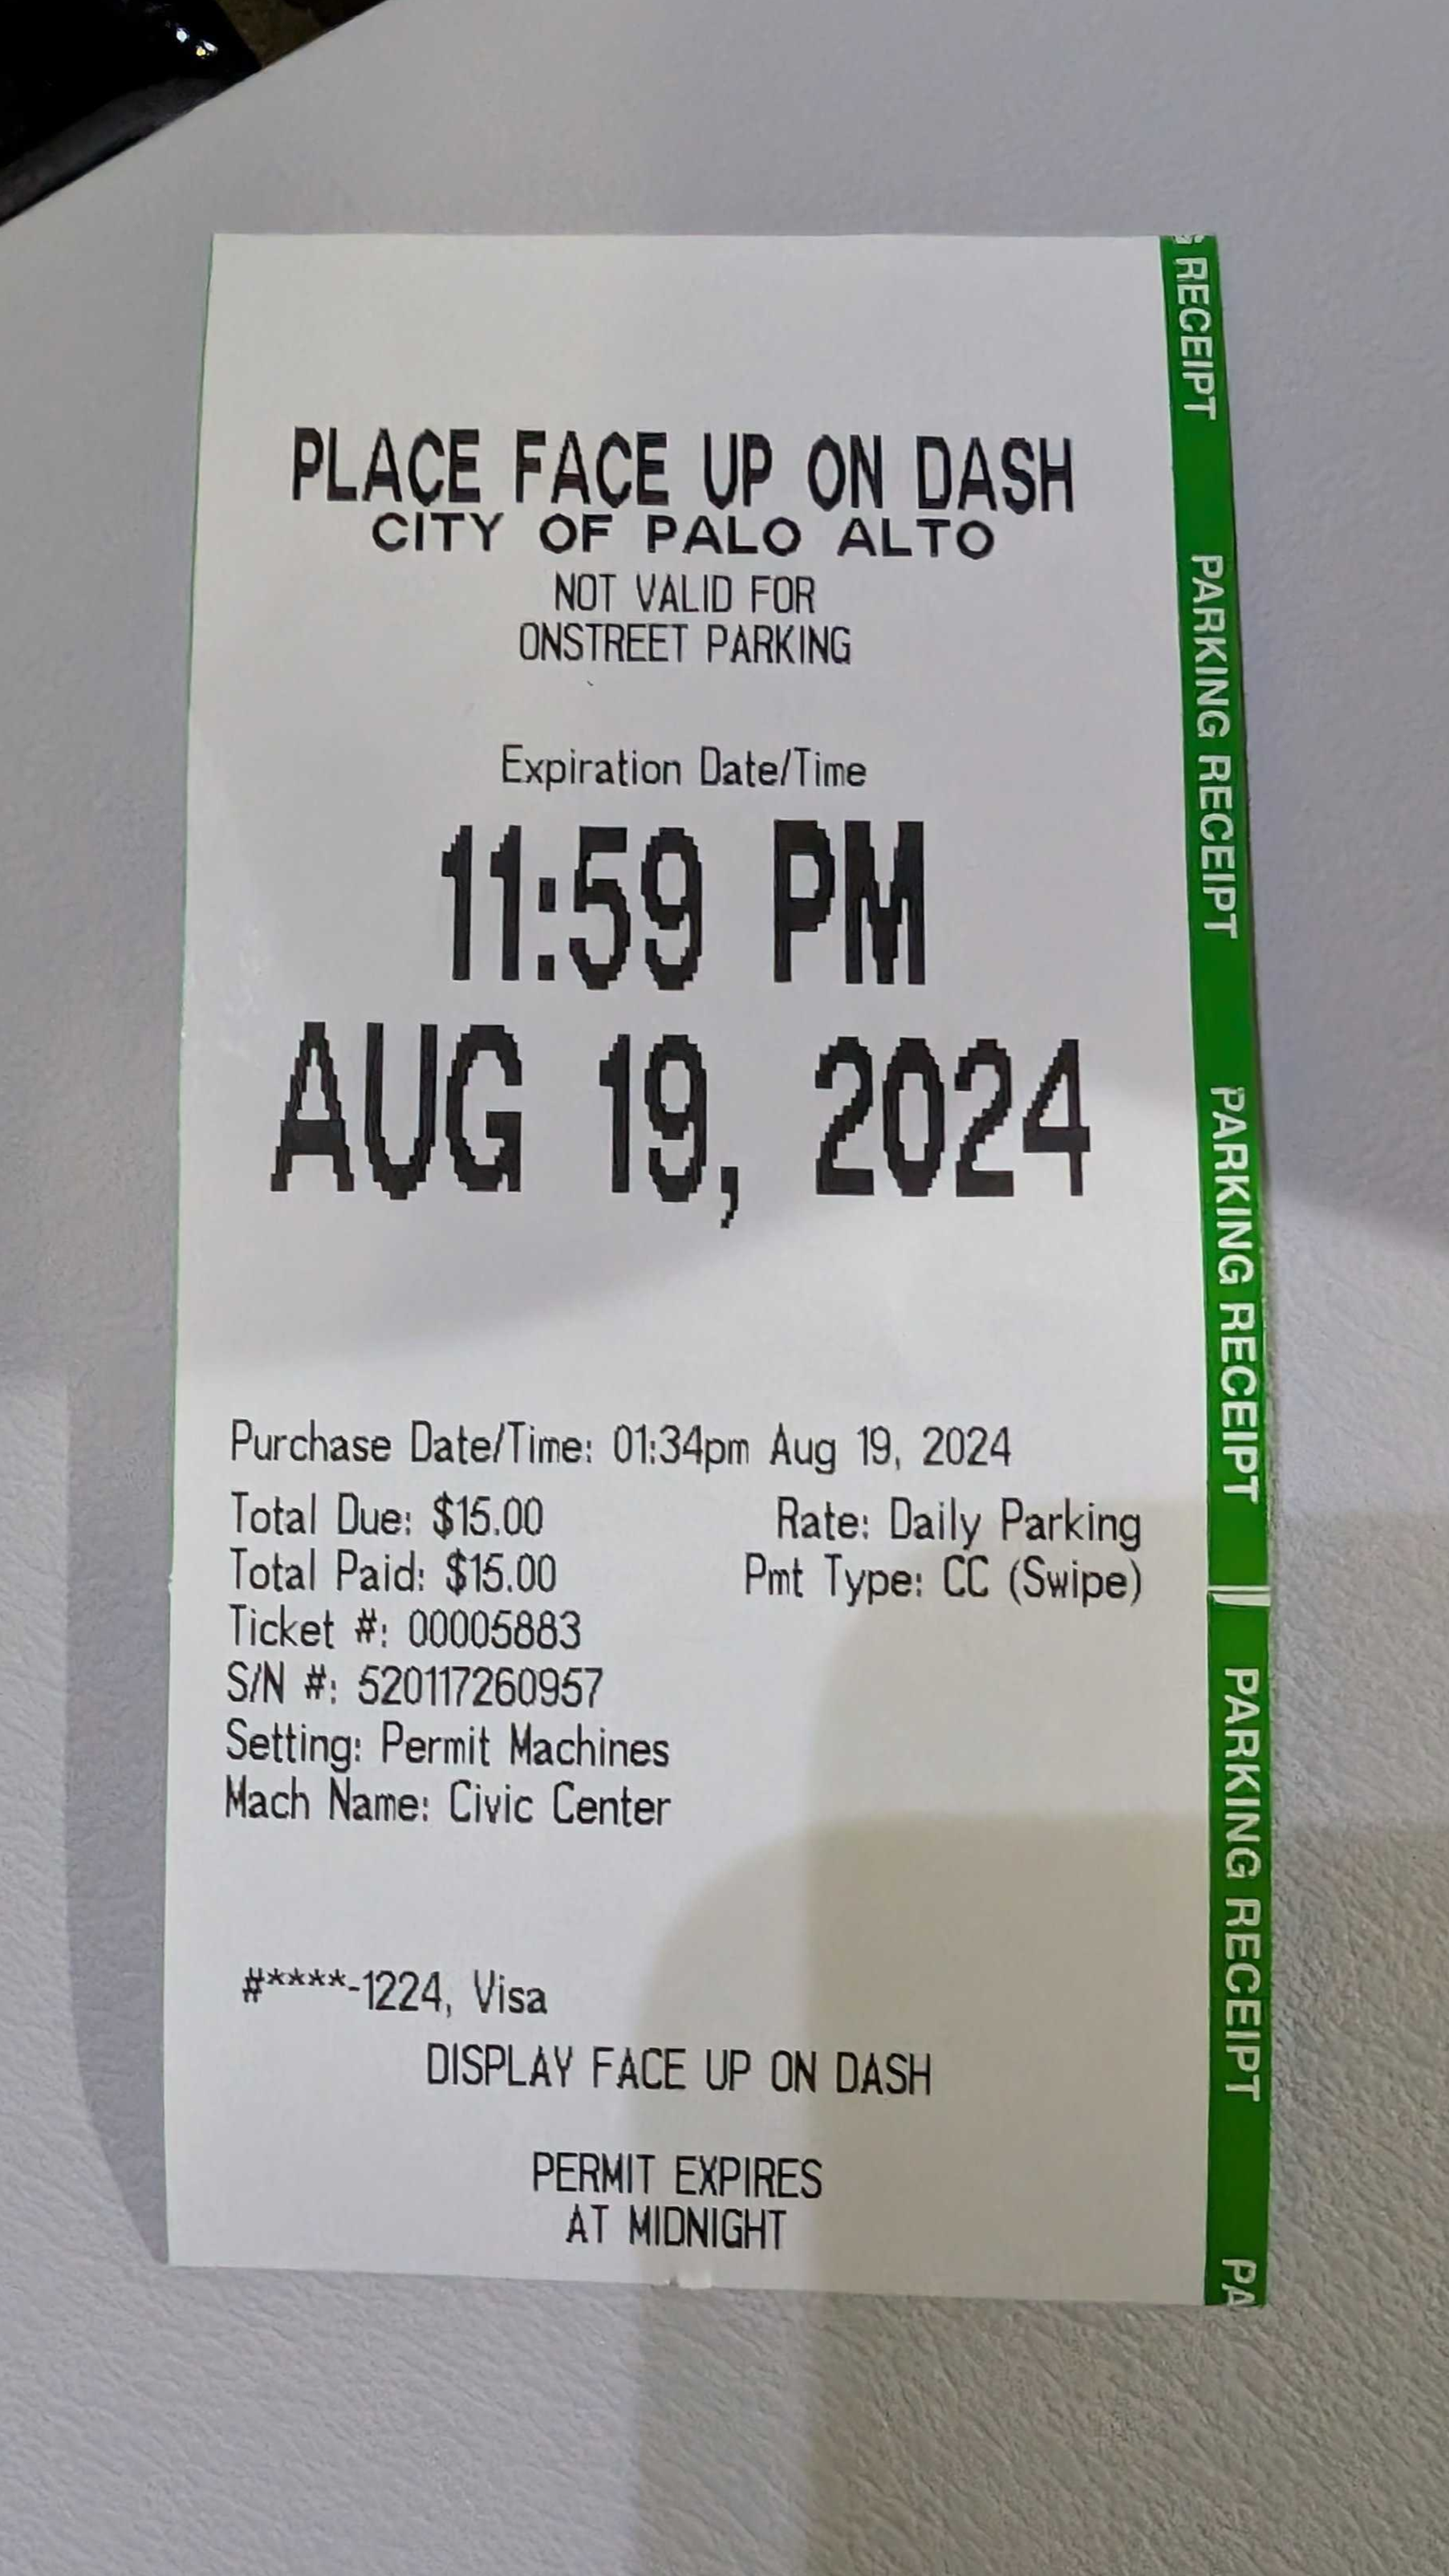

In [ ]:
from PIL import Image

image = Image.open(image_path)
image